# Libraries

In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor

from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import time
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import accuracy_score
from tscv import GapWalkForward
from sklearn.model_selection import cross_val_score
import statistics


Using Theano backend.


# Training data on historical data for threshold calculation

# Functions

In [33]:
# %%time
#split the dataset into train and test set
# split a univariate dataset into train/test sets
def split_dataset(data,hour_split):
    # split into standard hours
    
    train_start_index= 32
    train_end_index = 2224
    
    test_start_index= train_end_index
    test_end_index = test_start_index + hour_split
    
    train = data[train_start_index:train_end_index]
    
    test = data[test_start_index:test_end_index]
    
    # restructure into windows of weekly data
    train = array(split(train, len(train)/(hour_split)))
    #print("train data after splitting", train)
    #test and predict on the week ahead on hourly basis, predict for 24 hours ahead
    test = array(split(test, len(test)/(hour_split)))
    #print("test data after splitting", test)
    return train, test


In [34]:


#evaluate one or more forecast for week on hourly basis against expected values
def evaluate_forecasts(actual,predicted):
    scores=list()
    #for all columns, calculate RMSE score for each hour
    for i in range(actual.shape[1]):
        mse=mean_squared_error(actual[:,i],predicted[:,i])
        rmse=sqrt(mse)
        scores.append(rmse)
    #calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for column in range(actual.shape[1]):
            s+=(actual[row,column]-predicted[row,column])**2
    score=sqrt(s/(actual.shape[0]*actual.shape[1]))
    return score,scores


In [35]:

# summarize scores
def summarize_scores(name, score, scores, mape):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s [%.3f]' % (name, score, s_scores, mape)) 


In [36]:

    
#mean absolute percentage error
def mape_calculator(actual,predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
# prepare a list of ml models
def get_models(models=dict()):
    # linear models
    models['Linear Regression'] = LinearRegression()
    #models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    models['Support Vector Regression']=SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    models['Random Forest Regression']=RandomForestRegressor(max_depth=6, n_estimators=1000,random_state=False, verbose=False)
    models['Gradient Boosting Regression']=GradientBoostingRegressor(n_estimators=10000, learning_rate=0.01)
    print('Defined %d models' % len(models))
    return models

In [38]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [39]:
# make a recursive multi-step forecast
#X = [x1, x2, x3]
#y1 = model.predict(X)
#X = [x2, x3, y1]
#y2 = model.predict(X)
def forecast(model, input_x, n_input):
    yhat_sequence = list()
    input_data = [x for x in input_x]
    #print("input data outside for loop in forecast",input_data)
    #make range iterate to the number of hours to be forecasted
    for j in range(n_input):
        #print("how many times forecasting happens")
        # prepare the input data by taking last 24 values in sliding window manner
        #print("input data", input_data[-n_input:])
        #convert to a 2D array using reshape
        X = array(input_data[-n_input:]).reshape(1, n_input)
        # make a one step forecast
        yhat = model.predict(X)[0]
        # add to the result
        yhat_sequence.append(yhat)
        # add the prediction to the input
        input_data.append(yhat)
        #print(yhat_sequence)
    return yhat_sequence


In [40]:

# convert windows of 24 hourly multivariate data into a series of total power
def to_series(data):
    #print("inside to_series function", data)
    # extract just the total power from each hour
    series = [hour[:, 0] for hour in data]
    # flatten into a single series
    series = array(series).flatten()
    return series


In [41]:

# convert history into inputs and outputs
def to_supervised(history, n_input):
    # convert history to a univariate series
    data = to_series(history)
    X, y = list(), list()
    ix_start = 0
    # step over the entire history one time step at a time
    for i in range(len(data)):
        # define the end of the input sequence
        ix_end = ix_start + n_input
        # ensure we have enough data for this instance
        if ix_end < len(data):
            X.append(data[ix_start:ix_end])
            #print("X after converting data in supervised format", X)
            y.append(data[ix_end])
            #print("y after converting data in supervised format", y)
        # move along one time step
        ix_start += 1
    return array(X), array(y)

In [42]:

#X after converting data in supervised format [array([ 18.798,  17.068,  18.596,  61.58 ,  17.61 ,  36.6  , 147.026,
#       124.928,  97.76 ,  78.578,  93.716, 105.364, 100.924, 103.982,
#       107.058, 116.958, 129.294, 144.152, 156.87 , 183.034, 130.184,
#       104.328,  92.836,  50.228]), array([ 17.068,  18.596,  61.58 ,  17.61 ,  36.6  , 147.026, 124.928,
#        97.76 ,  78.578,  93.716, 105.364, 100.924, 103.982, 107.058,
#       116.958, 129.294, 144.152, 156.87 , 183.034, 130.184, 104.328,
#        92.836,  50.228,  21.182])]
#y after converting data in supervised format [21.181999999999995, 19.63399999999999]

# fit a model and make a forecast
def sklearn_predict(model, history, n_input):
    # prepare data
    #print("inside sklearn_predict", len(history))
    #print(n_input)
    train_x, train_y = to_supervised(history, n_input)
    
    
    #print("train data inputs", train_x, len())
    #print("train data output", train_y)
    # make pipeline
    pipeline = make_pipeline(model)
    # fit the model
    #print("training data", train_x)
    pipeline.fit(train_x, train_y)
    # predict the coming 24 hours, recursively
    #print("train_x data", train_x, train_x.shape)
    #print("train data to fit the model", train_x[-1, :])
    #last row of 24 hours as input for forecasting next 24 hours 
    yhat_sequence = forecast(pipeline, train_x[-1, :], n_input)
    return yhat_sequence,train_x, train_y

In [43]:
# evaluate a single model
def evaluate_model_json(model, train, test, n_input):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = sklearn_predict(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [44]:
# evaluate a single model using walk forward validation technique
def evaluate_model(model, train, test, n_input):
    
    # history is a list of daily 24 hours data
    history = [x for x in train]
    # walk-forward validation over next 24 hours
    predictions = list()
    #for i in range(len(test)):
        
        # predict next 24 hours
        #print("Inside evaluate_model", history)
    yhat_sequence,train_x,train_y = sklearn_predict(model, history, n_input)
        #print("after predictions", yhat_sequence)
        # store the predictions
    predictions.append(yhat_sequence)
        # get real observation and add to history 
    #history.append(test[i, :])
        
    predictions = array(predictions)

    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    
    return score, scores, predictions,train_x, train_y


In [45]:
def find_anamolies(error_list,threshold):
    anamoly_list = [None]*len(error_list)
    anamoly_list_indices = []
    for i,error in enumerate(error_list):
        if error > threshold:
            anamoly_list[i]=error
            anamoly_list_indices.append(i)
    return anamoly_list,anamoly_list_indices

In [46]:
def new_evaluation(dataset, n_input,hours,anamoly_threshold,number_of_folds):
    
    all_result = []
    
    train, test = split_dataset(dataset.values,n_input)
    
    
    models = get_models()
    for name, model in models.items():
        #if name == "Linear Regression":
            # dictionary to store the otuput of each models
            result_dict={}

            # evaluate and get scores and predictions
            start_time = time.time()
            score, scores, predictions,train_x, train_y = evaluate_model(model, train, test, n_input)
            end_time = time.time()
            time_taken_in_seconds = end_time - start_time

            # 10 fold GapWalkForward validation on train and test data 
            clf = model
            cv = GapWalkForward(n_splits=number_of_folds, gap_size=1, test_size=n_input)
            validation_scores = cross_val_score(clf, train_x, train_y, cv=cv)


            test_flatten = array(test).flatten()
            predict_flatten = array(predictions).flatten()
            error= abs(test_flatten-predict_flatten)
            #added mape calculator
            mape=mape_calculator(test, predictions)

            # summarize scores
            summarize_scores(name, score, scores, mape)


            result_dict["model_name"]=name
            result_dict["validation_scores"]=validation_scores
            result_dict["execution_time"]=time_taken_in_seconds
            result_dict["predict_flatten"]=predict_flatten
            result_dict["test_flatten"]=test_flatten
            result_dict["error"]=error
            result_dict["mape"] = mape
            result_dict["score"] = score
            result_dict["scores"] = scores
            std_of_scores = statistics.stdev(scores)
            result_dict["anamoly_threshold_std_of_scores"]=std_of_scores*2
            result_dict["anamoly_list"],result_dict["anamoly_indices"] = find_anamolies(error,(std_of_scores*2))
            #result_dict["anamoly_list"],result_dict["anamoly_indices"] = find_anamolies(error,anamoly_threshold)


            all_result.append(result_dict)

    return all_result

In [47]:
def new_evaluation_without_cross_fold(dataset, n_input,hours,anamoly_threshold,number_of_folds):
    
    all_result = []
    
    train, test = split_dataset(dataset.values,n_input)
    
    
    models = get_models()
    for name, model in models.items():
        #if name == "Linear Regression":
            # dictionary to store the otuput of each models
            result_dict={}
            
            # evaluate and get scores and predictions
            start_time = time.time()
            score, scores, predictions,train_x, train_y = evaluate_model(model, train, test, n_input)
            end_time = time.time()
            time_taken_in_seconds = end_time - start_time

            # 10 fold GapWalkForward validation on train and test data 
            #clf = model
            #cv = GapWalkForward(n_splits=number_of_folds, gap_size=1, test_size=n_input)
            #validation_scores = cross_val_score(clf, train_x, train_y, cv=cv)


            test_flatten = array(test).flatten()
            predict_flatten = array(predictions).flatten()
            error= abs(test_flatten-predict_flatten)
            #added mape calculator
            mape=mape_calculator(test, predictions)

            # summarize scores
            summarize_scores(name, score, scores, mape)


            result_dict["model_name"]=name
            #result_dict["validation_scores"]=validation_scores
            result_dict["execution_time"]=time_taken_in_seconds
            result_dict["predict_flatten"]=predict_flatten
            result_dict["test_flatten"]=test_flatten
            result_dict["error"]=error
            result_dict["mape"] = mape
            result_dict["score"] = score
            result_dict["scores"] = scores
            std_of_scores = statistics.stdev(scores)
            result_dict["anamoly_threshold_std_of_scores"]=std_of_scores*3
            result_dict["anamoly_list"],result_dict["anamoly_indices"] = find_anamolies(error,(std_of_scores*2))
            #result_dict["anamoly_list"],result_dict["anamoly_indices"] = find_anamolies(error,anamoly_threshold)


            all_result.append(result_dict)

    return all_result

In [48]:
def draw_graphs_rmse_scores(df,x_axis,y_axis_name):
    pyplot.figure(figsize=(20,10))
    for index,row in df.iterrows():
        pyplot.plot(x_axis, row[y_axis_name], marker='o', label=row['model_name'])
    pyplot.suptitle('RMSE error for predicted '+ str(len(x_axis)) +' hours', fontsize = 'xx-large')
    pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
    pyplot.ylabel('RMSE Scores (KW)', fontsize = 'xx-large')
    pyplot.legend(fontsize = 'xx-large')

    pyplot.show()

In [49]:
def draw_graphs_predicted_vs_actual_combined(df,x_axis):
    pyplot.figure(figsize=(20,10))
    count = 0
    for index,row in df.iterrows():
        
        
        test=row['test_flatten']
        anamoly_list = [None]*len(test)
        anamolies_indices = row['anamoly_indices']
        for ind in anamolies_indices:
            anamoly_list[ind] = test[ind]
        
        if count == 0:
            pyplot.plot(x_axis,row['test_flatten'], marker='o',color='blue', label="Actual")
            count=count+1
        pyplot.plot(x_axis,row['predict_flatten'],marker='o', label=row['model_name'])
        pyplot.scatter(x_axis,anamoly_list, label=row['model_name'],s=200)
    
    #pyplot.suptitle(str(row['model_name'])+' : Actual Vs Predicted for '+ str(len(x_axis)) +' hours', fontsize=16)
    pyplot.suptitle('Actual Vs Predicted for '+ str(len(x_axis)) +' hours', fontsize = 'xx-large')
    pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
    pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
    #pyplot.legend(["Actual Power","Predicted Power","Anamolies"])
    pyplot.legend(fontsize = 'xx-large')
    pyplot.show()
        

In [50]:
def draw_graphs_predicted_vs_actual(df,x_axis):
    for index,row in df.iterrows():
        
        
        test=row['test_flatten']
        anamoly_list = [None]*len(test)
        anamolies_indices = row['anamoly_indices']
        for ind in anamolies_indices:
            anamoly_list[ind] = test[ind]
        
        pyplot.figure(figsize=(20,10))
        pyplot.plot(x_axis,row['test_flatten'], color='blue', label='Real power')
        pyplot.plot(x_axis,row['predict_flatten'], color= 'green', label='Predictions')
        pyplot.scatter(x_axis,anamoly_list, color= 'red', label='Anamolies',s=200)
        pyplot.suptitle(str(row['model_name'])+' : Actual Vs Predicted for '+ str(len(x_axis))+ ' hours', fontsize = 'xx-large')
        pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
        pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
        pyplot.legend(["Actual Power","Predicted Power","Anamolies"],fontsize = 'xx-large')
        pyplot.show()
        

In [51]:
def draw_graphs_predicted_vs_actual_alone(df,x_axis):
    for index,row in df.iterrows():
        
        
        test=row['test_flatten']
        anamoly_list = [None]*len(test)
        anamolies_indices = row['anamoly_indices']
        for ind in anamolies_indices:
            anamoly_list[ind] = test[ind]
        
        pyplot.figure(figsize=(20,10))
        pyplot.plot(x_axis,row['test_flatten'], color='blue', label='Real power')
        pyplot.plot(x_axis,row['predict_flatten'], color= 'green', label='Predictions')
        #pyplot.scatter(x_axis,anamoly_list, color= 'red', label='Anamolies',s=200)
        pyplot.suptitle(str(row['model_name'])+' : Actual Vs Predicted for '+str(len(x_axis))+ ' hours', fontsize = 'xx-large')
        pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
        pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
        #pyplot.legend(["Actual Power","Predicted Power","Anamolies"])
        pyplot.legend(["Actual Power","Predicted Power"],fontsize = 'xx-large')
        pyplot.show()
        

In [52]:
def draw_graphs_anamolies_seperately(df,x_axis):
    for index,row in df.iterrows():
        
        
        test=row['test_flatten']
        anamoly_list = [None]*len(test)
        anamolies_indices = row['anamoly_indices']
        for ind in anamolies_indices:
            anamoly_list[ind] = test[ind]
        
        pyplot.figure(figsize=(20,10))
        pyplot.plot(x_axis,row['test_flatten'], color='blue', label='Real power')
        #pyplot.plot(x_axis,row['predict_flatten'], color= 'green', label='Predictions')
        pyplot.scatter(x_axis,anamoly_list, color= 'red', label='Anamolies',s=200)
        pyplot.suptitle(str(row['model_name'])+' : Anamolies for '+str(len(x_axis))+' hours', fontsize = 'xx-large')
        pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
        pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
        pyplot.legend(["Power Consumption","Anamolies"],fontsize = 'xx-large')
        pyplot.show()
        

In [53]:
def draw_graphs_common_anamolies(df,x_axis):
    
    all_anamoly_indices = df['anamoly_indices'].values.tolist()
    common_anamolies = list(set(all_anamoly_indices[0]).intersection(*all_anamoly_indices[1:]))
    
    test=df["test_flatten"].iloc[0].tolist()
    print("TEST", test)
    #for index,row in df.iterrows():
        
        
    #test=row['test_flatten']
    anamoly_list = [None]*len(test)
    anamolies_indices = common_anamolies
    for ind in anamolies_indices:
        anamoly_list[ind] = test[ind]

    pyplot.figure(figsize=(20,10))
    pyplot.plot(x_axis,test, color='blue', label='Real power')
    #pyplot.plot(x_axis,row['predict_flatten'], color= 'green', label='Predictions')
    pyplot.scatter(x_axis,anamoly_list, color= 'red', label='Anamolies',s=200)
    pyplot.suptitle('Final Common Anamolies for '+str(len(x_axis))+' hours', fontsize = 'xx-large')
    pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
    pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
    pyplot.legend(["Power Consumption","Anamolies"],fontsize = 'xx-large')
    pyplot.show()
        

In [54]:
def final_graphs_anamolies_seperately(df,x_axis):
    for index,row in df.iterrows():
        
        
        test=row['test_flatten']
        anamoly_list = [None]*len(test)
        anamolies_indices = row['anamoly_indices']
        for ind in anamolies_indices:
            anamoly_list[ind] = test[ind]
        
        pyplot.figure(figsize=(20,10))
        pyplot.plot(x_axis,row['test_flatten'], color='blue', label='Real power')
        #pyplot.plot(x_axis,row['predict_flatten'], color= 'green', label='Predictions')
        pyplot.scatter(x_axis,anamoly_list, color= 'red', label='Anamolies',s=200)
        pyplot.suptitle('Anamolies based on Anamoly Detection Algorithm ', fontsize = 'xx-large')
        pyplot.xlabel('Hours(H)', fontsize = 'xx-large')
        pyplot.ylabel('Power Consumption(KW)', fontsize = 'xx-large')
        pyplot.legend(["Power Consumption","Anamolies"],fontsize = 'xx-large')
        pyplot.show()
        

In [55]:
def draw_bar_execution_time(df,title):  
    ax = df.plot(x='model_name', y='execution_time',
               alpha=0.75, rot=0,
               kind='bar', title ="Execution Time Comparison - " + title,
               figsize=(15, 10), legend=False, 
               fontsize=12)
    ax.set_xlabel("Model Name", fontsize = 'xx-large')
    ax.set_ylabel("Execution Time (seconds)", fontsize = 'xx-large')
    plt.show()


In [56]:
def draw_validation_scores_graph(df,x_axis,y_axis_name,title):
    pyplot.figure(figsize=(20,10))
    for index,row in df.iterrows():
        pyplot.plot(x_axis, row[y_axis_name], marker='o', label=row['model_name'])
    pyplot.suptitle('Validation score - Using  "'+ str(len(x_axis)) +'" Folds for '+ str(title) +' hours', fontsize = 'xx-large')
    pyplot.xlabel('Fold', fontsize = 'xx-large')
    pyplot.ylabel('Validation Scores', fontsize = 'xx-large')
    pyplot.legend(fontsize = 'xx-large')

    pyplot.show()

# Reading Csv File

In [57]:

# load the new file
dataset = read_csv('household_power_consumption_hourly.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])


In [58]:
dataset.head()

,Global_active_power
datetime,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


In [59]:
dataset.columns

Index(['Global_active_power'], dtype='object')

In [60]:
len(dataset.values)

34589

# Calling for 16 hours

In [61]:
n_input = 16
number_of_folds = 10
hours = list(range(1,n_input+1))
hours = list(map(str, hours))
anamoly_threshold = 90

In [62]:
#final_output_16_hours = new_evaluation(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_output_16_hours = new_evaluation_without_cross_fold(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_output_16_hours_df = pd.DataFrame(final_output_16_hours)

Defined 4 models
Linear Regression: [66.955] 20.8, 15.5, 28.0, 51.9, 44.4, 42.7, 31.2, 35.5, 27.0, 22.7, 122.6, 147.0, 130.5, 20.4, 29.7, 72.9 [74.435]
Support Vector Regression: [78.476] 14.4, 4.6, 20.2, 50.9, 41.7, 49.8, 40.8, 45.6, 40.4, 40.7, 146.5, 176.3, 162.2, 50.9, 3.2, 50.9 [67.100]
Random Forest Regression: [56.462] 15.6, 17.9, 37.0, 72.9, 67.5, 14.8, 6.5, 9.1, 25.8, 31.7, 66.6, 98.4, 84.0, 19.4, 67.7, 105.1 [104.119]
Gradient Boosting Regression: [71.333] 7.8, 0.4, 40.2, 97.5, 88.7, 32.7, 17.1, 36.0, 34.4, 21.0, 135.6, 143.6, 111.8, 7.1, 29.3, 75.3 [82.345]


In [33]:
final_output_16_hours_df.head()

,anamoly_indices,anamoly_list,anamoly_threshold_std_of_scores,error,execution_time,mape,model_name,predict_flatten,score,scores,test_flatten
0,"[2, 3, 4, 13, 14, 15]","[None, None, 54.217459419392355, 61.6873148441...",60.047691,"[18.750164996689563, 21.990513226577427, 54.21...",0.015259,180.151426,Linear Regression,"[57.052164996689555, 58.4745132265774, 71.4474...",37.242451,"[18.750164996689563, 21.990513226577427, 54.21...","[38.30199999999999, 36.48399999999997, 17.2300..."
1,"[2, 3, 4, 6, 7, 9, 10, 13, 14, 15]","[None, None, 39.89383170731499, 39.13534993562...",45.788070,"[19.71753913380965, 18.548911423360117, 39.893...",0.248013,142.033466,Support Vector Regression,"[58.019539133809644, 55.03291142336009, 57.123...",36.101558,"[19.71753913380965, 18.548911423360117, 39.893...","[38.30199999999999, 36.48399999999997, 17.2300..."
2,"[7, 13, 14, 15]","[None, None, None, None, None, None, None, 62....",92.480720,"[3.713684407054515, 7.211773058307628, 29.5029...",10.130404,166.681599,Random Forest Regression,"[42.01568440705451, 43.6957730583076, 46.73292...",48.499820,"[3.713684407054515, 7.211773058307628, 29.5029...","[38.30199999999999, 36.48399999999997, 17.2300..."
3,"[13, 14, 15]","[None, None, None, None, None, None, None, Non...",110.343535,"[1.7316069744347686, 6.977756354302969, 26.376...",28.982907,189.896100,Gradient Boosting Regression,"[36.570393025565224, 43.46175635430294, 43.606...",49.740639,"[1.7316069744347686, 6.977756354302969, 26.376...","[38.30199999999999, 36.48399999999997, 17.2300..."


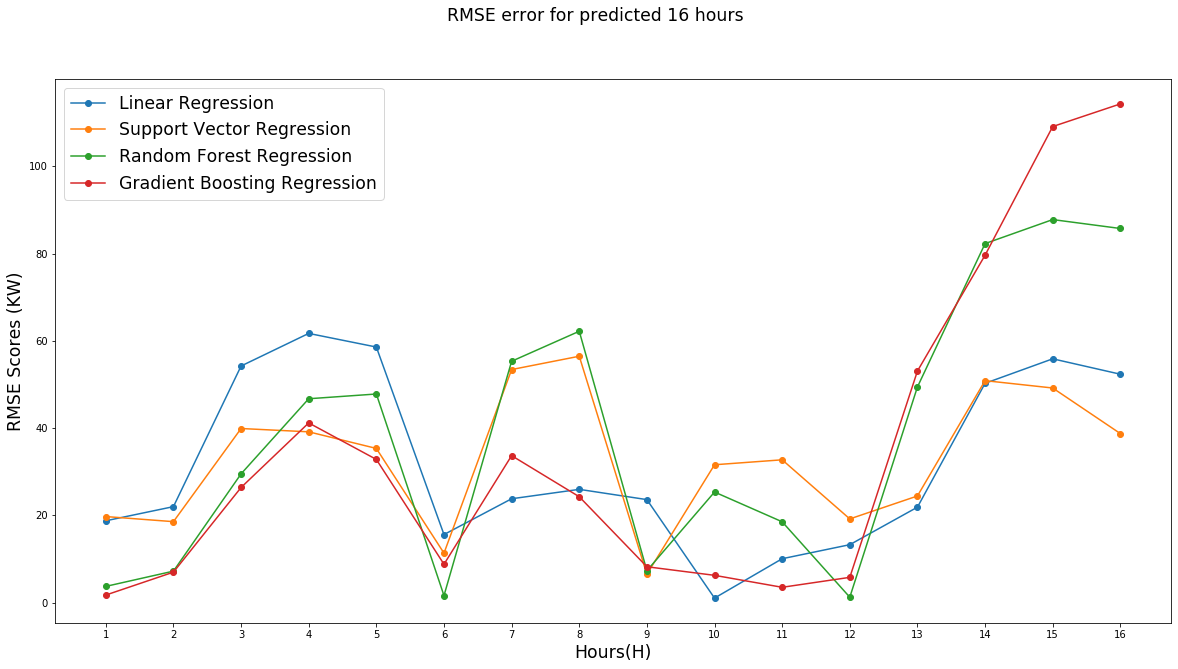

In [34]:
draw_graphs_rmse_scores(final_output_16_hours_df,hours,'scores')

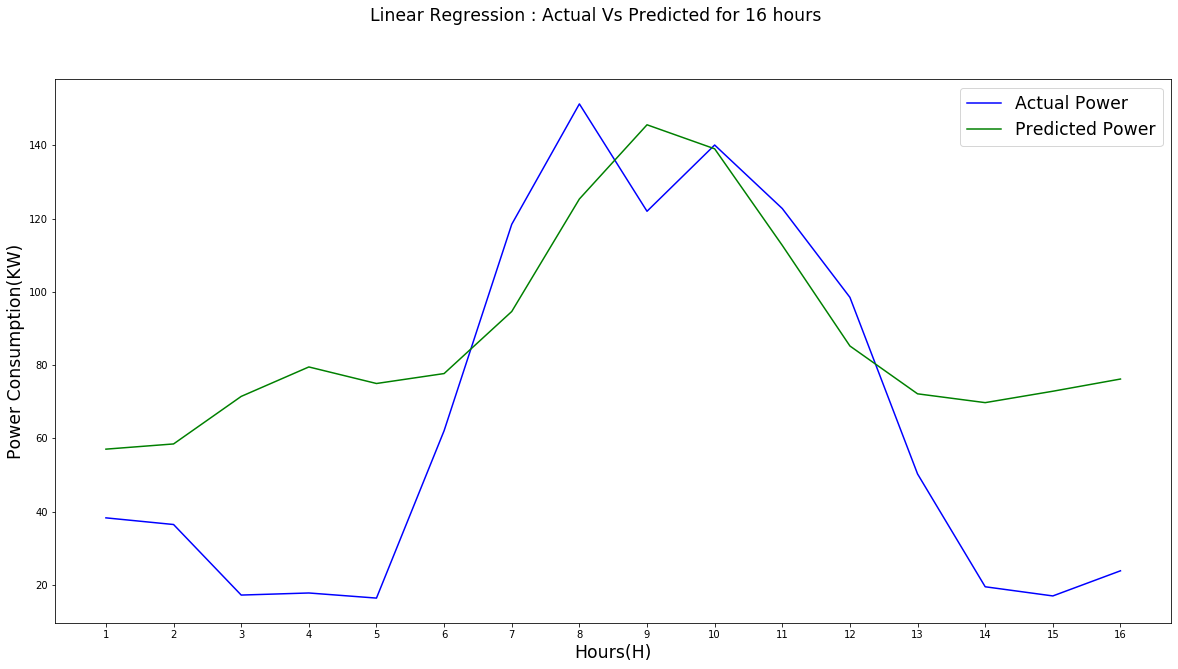

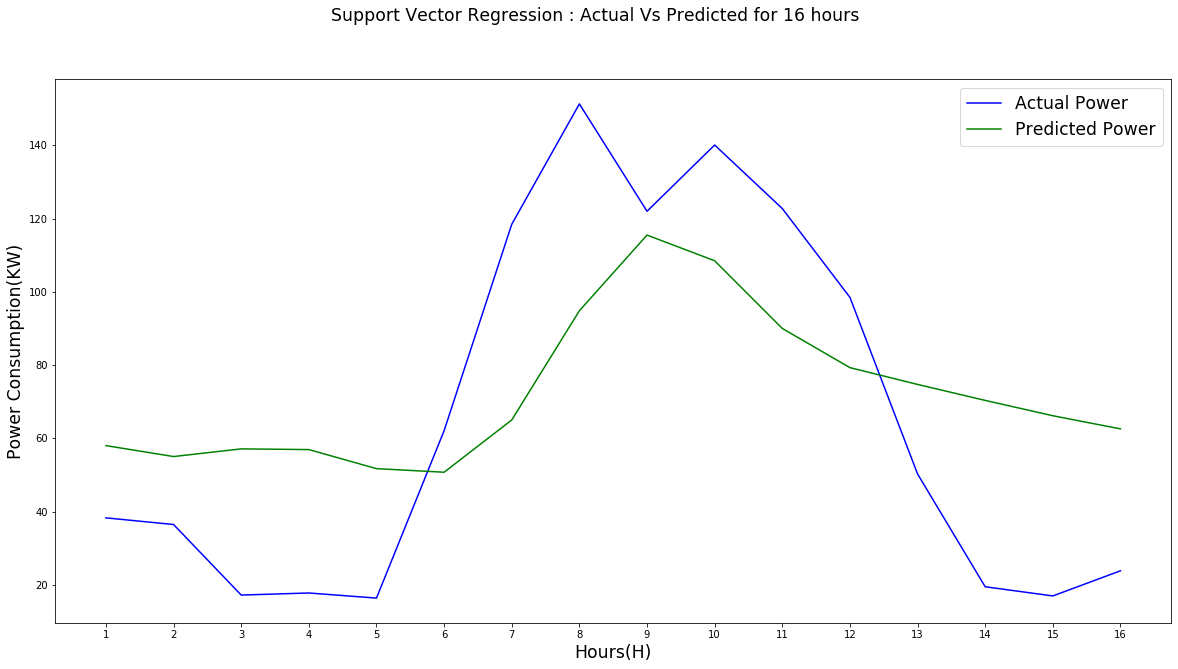

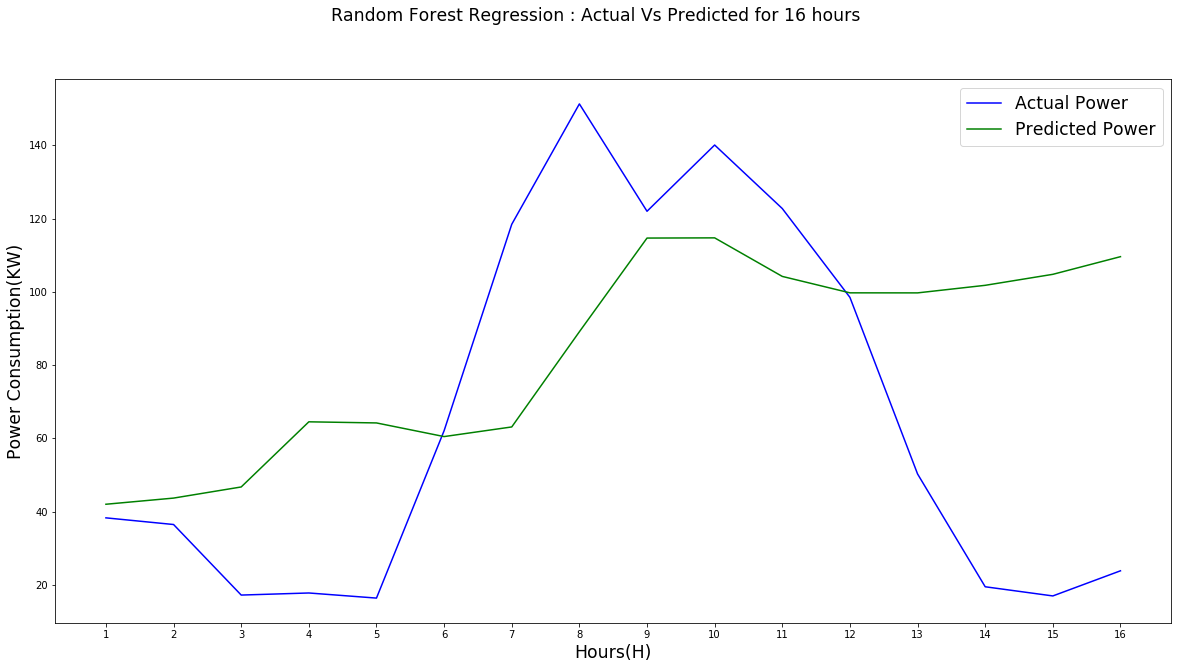

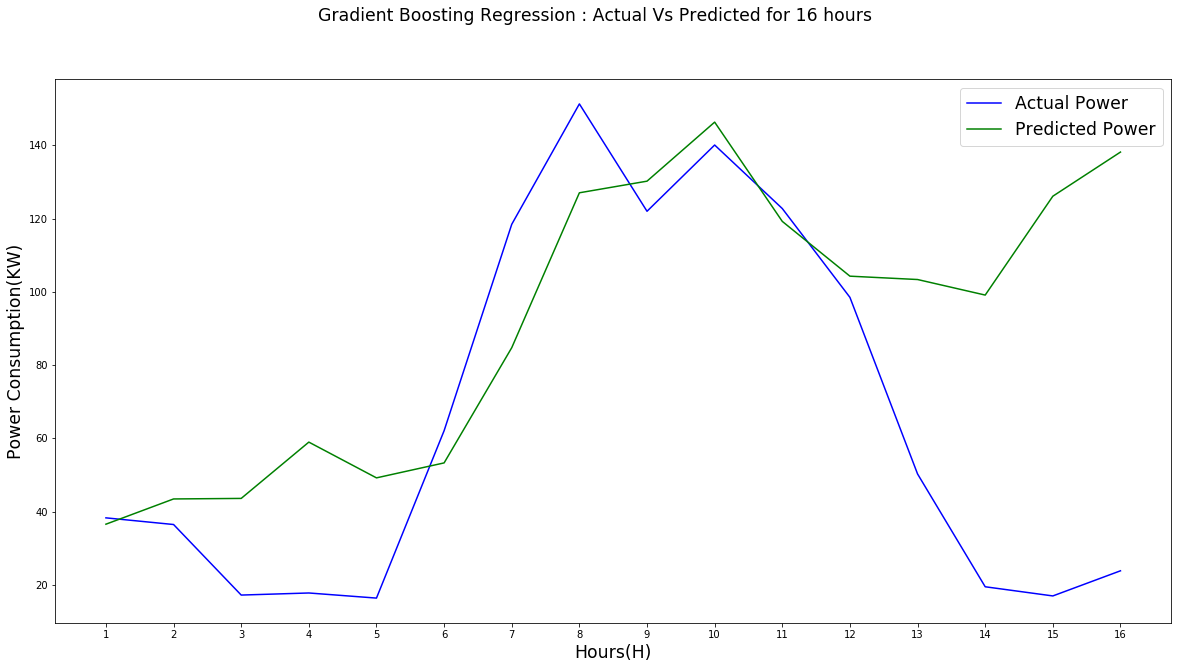

In [35]:
#draw_graphs_predicted_vs_actual(final_output_16_hours_df,hours)
draw_graphs_predicted_vs_actual_alone(final_output_16_hours_df,hours)

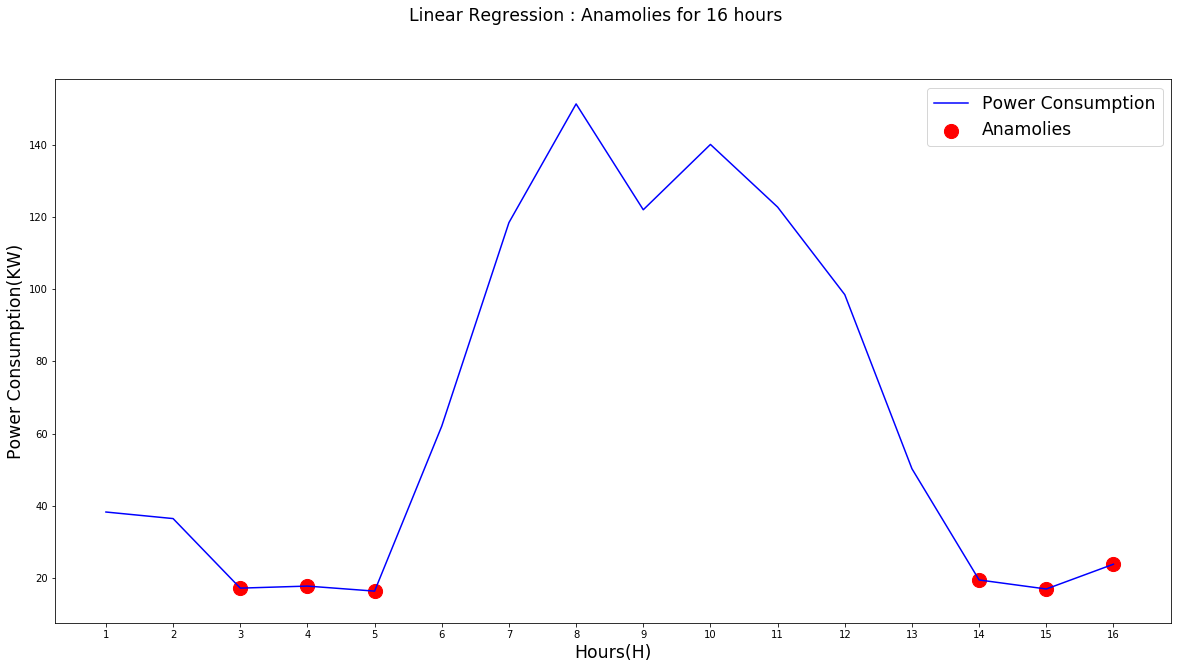

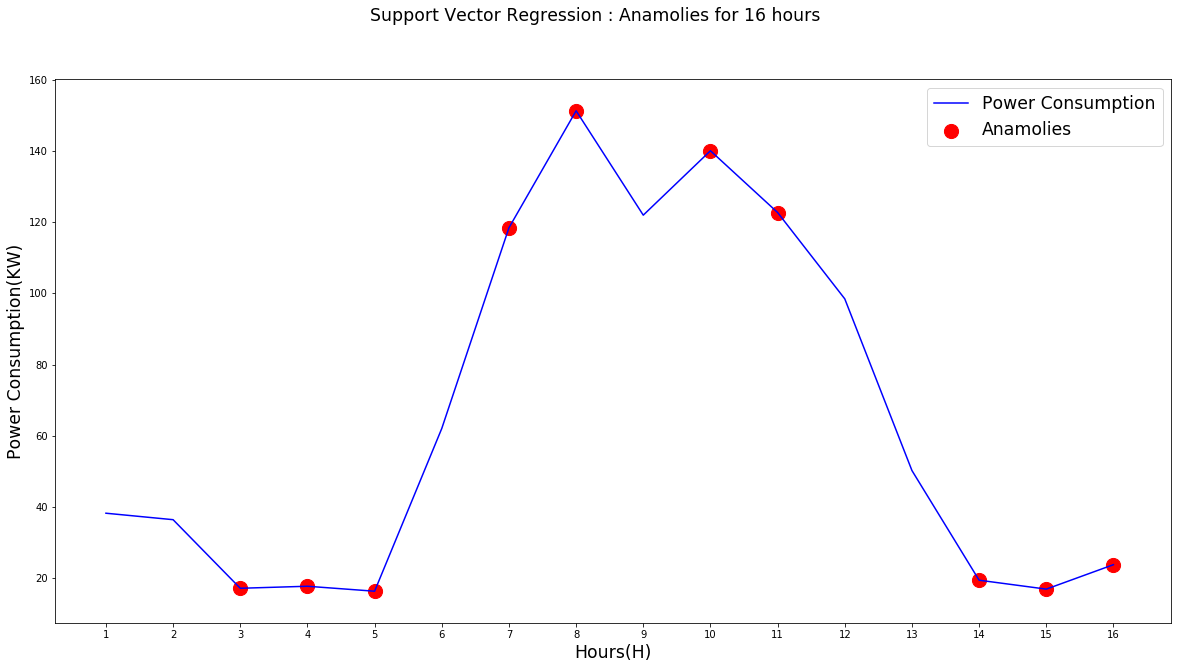

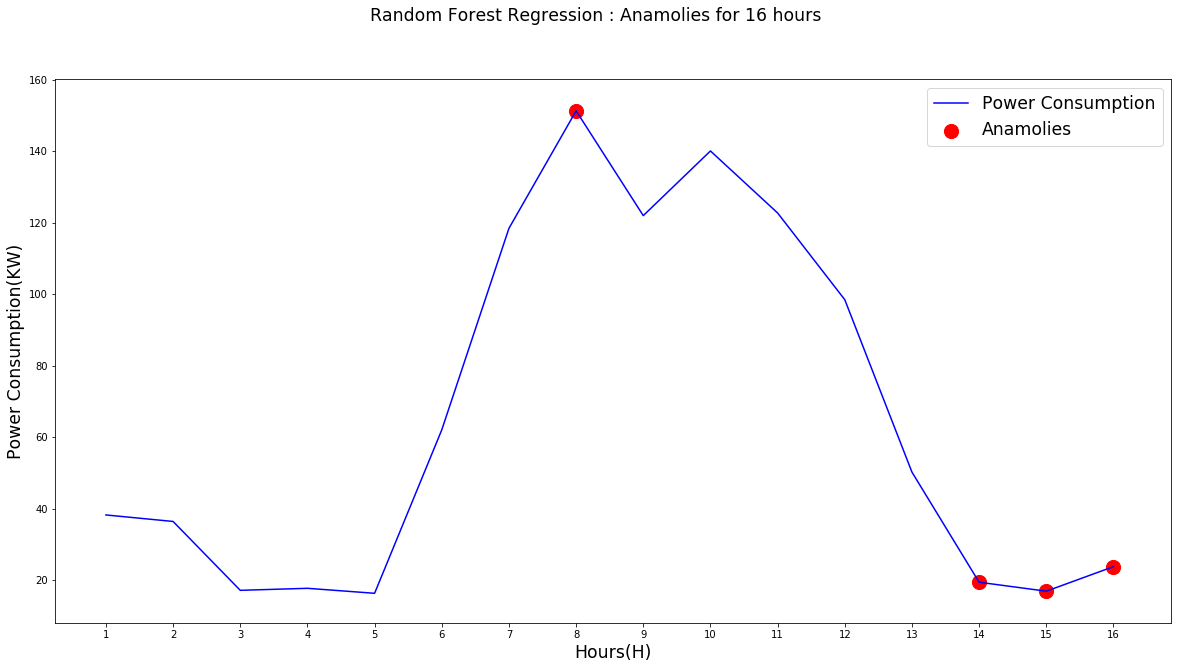

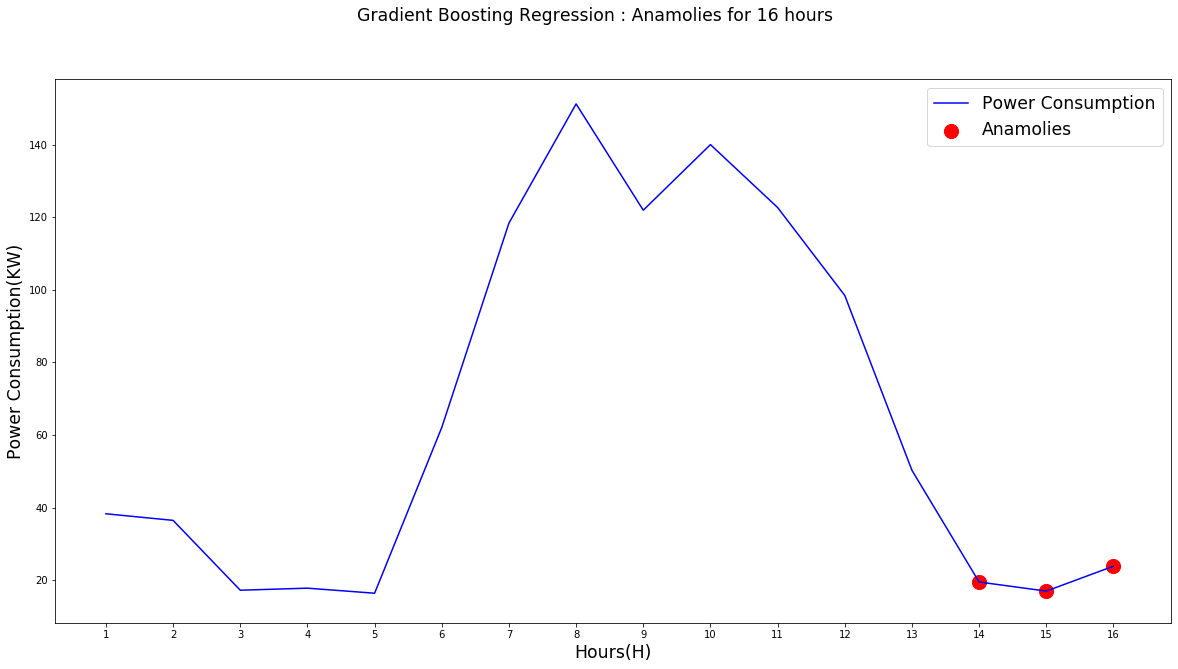

In [36]:
draw_graphs_anamolies_seperately(final_output_16_hours_df,hours)

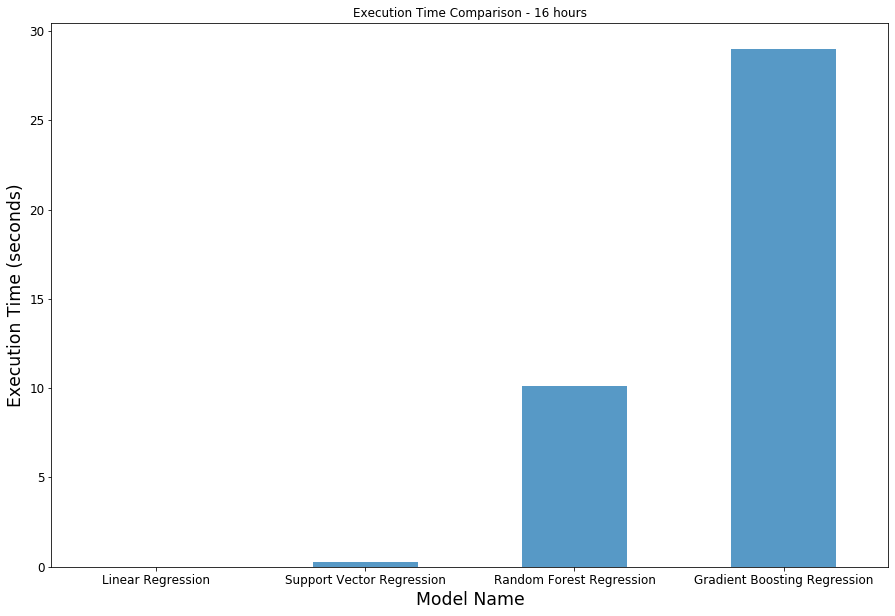

In [37]:
draw_bar_execution_time(final_output_16_hours_df,str(n_input)+" hours")

In [38]:
#draw_validation_scores_graph(final_output_16_hours_df,range(1,number_of_folds+1),'validation_scores',n_input)

In [39]:
all_anamoly_indices = final_output_16_hours_df['anamoly_indices'].values.tolist()
all_anamoly_indices

[[2, 3, 4, 13, 14, 15],
 [2, 3, 4, 6, 7, 9, 10, 13, 14, 15],
 [7, 13, 14, 15],
 [13, 14, 15]]

In [40]:
common_anamolies = list(set(all_anamoly_indices[0]).intersection(*all_anamoly_indices[1:]))
common_anamolies

[13, 14, 15]

[38.30199999999999, 36.48399999999997, 17.230000000000004, 17.797999999999995, 16.404, 62.088, 118.418, 151.274, 121.97400000000003, 140.054, 122.71799999999996, 98.476, 50.28200000000002, 19.494, 16.992, 23.852000000000004]


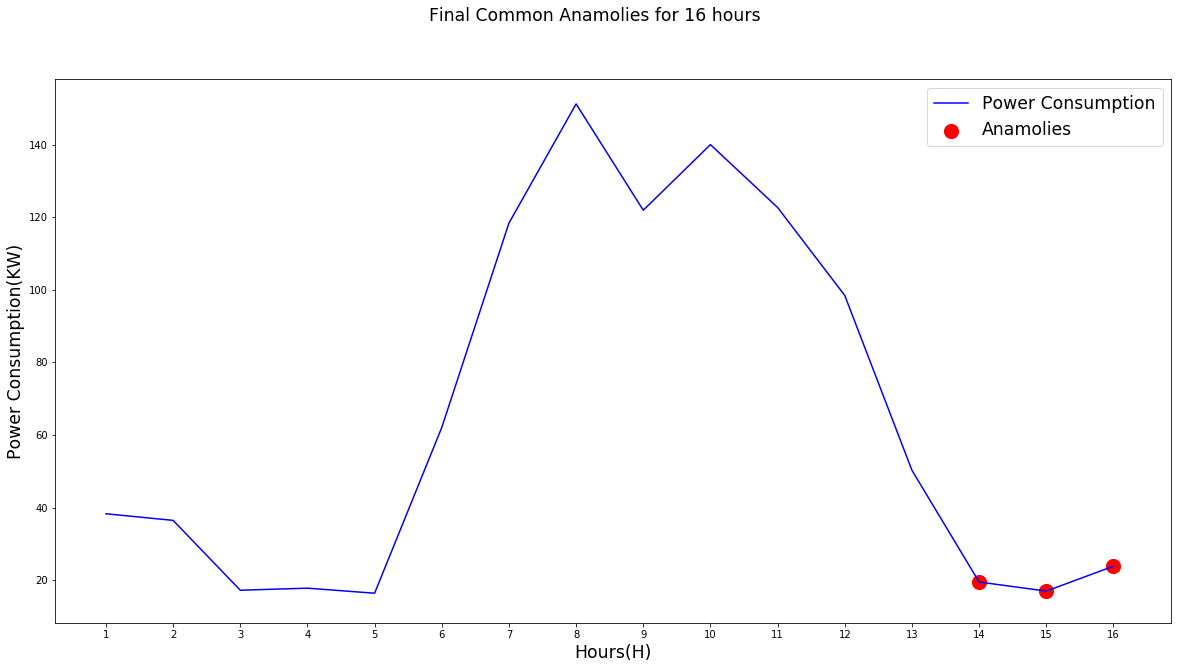

In [41]:
draw_graphs_common_anamolies(final_output_16_hours_df,hours)

# Calling for 24 hours

In [43]:
n_input = 24
number_of_folds = 10
hours = list(range(1,n_input+1))
hours = list(map(str, hours))
anamoly_threshold = 90

In [44]:
#final_output_24_hours = new_evaluation(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_output_24_hours = new_evaluation_without_cross_fold(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_df_24_hours = pd.DataFrame(final_output_24_hours)

Defined 4 models
Linear Regression: [52.382] 16.1, 15.5, 42.4, 43.6, 37.9, 2.8, 39.4, 42.2, 9.0, 12.1, 19.3, 24.1, 9.7, 39.1, 47.4, 46.0, 51.9, 16.9, 94.5, 13.9, 177.5, 67.1, 36.2, 17.7 [147.560]
Support Vector Regression: [58.991] 15.6, 12.9, 30.7, 27.7, 24.8, 23.0, 61.0, 61.7, 8.5, 31.2, 33.5, 25.1, 17.3, 44.6, 44.4, 36.7, 39.6, 2.4, 121.4, 39.6, 197.1, 82.8, 24.6, 11.8 [126.226]
Random Forest Regression: [60.626] 4.5, 7.2, 25.5, 27.5, 30.3, 17.5, 37.9, 55.0, 6.3, 28.3, 19.2, 2.2, 50.7, 82.2, 84.5, 81.9, 91.2, 61.1, 62.2, 0.9, 180.3, 70.9, 42.8, 37.3 [164.935]
Gradient Boosting Regression: [48.435] 11.1, 12.2, 6.0, 2.8, 7.6, 42.1, 77.2, 39.3, 18.8, 11.4, 5.1, 4.7, 50.9, 69.0, 51.4, 13.4, 28.5, 9.5, 105.1, 30.0, 139.7, 54.2, 24.9, 4.0 [149.487]


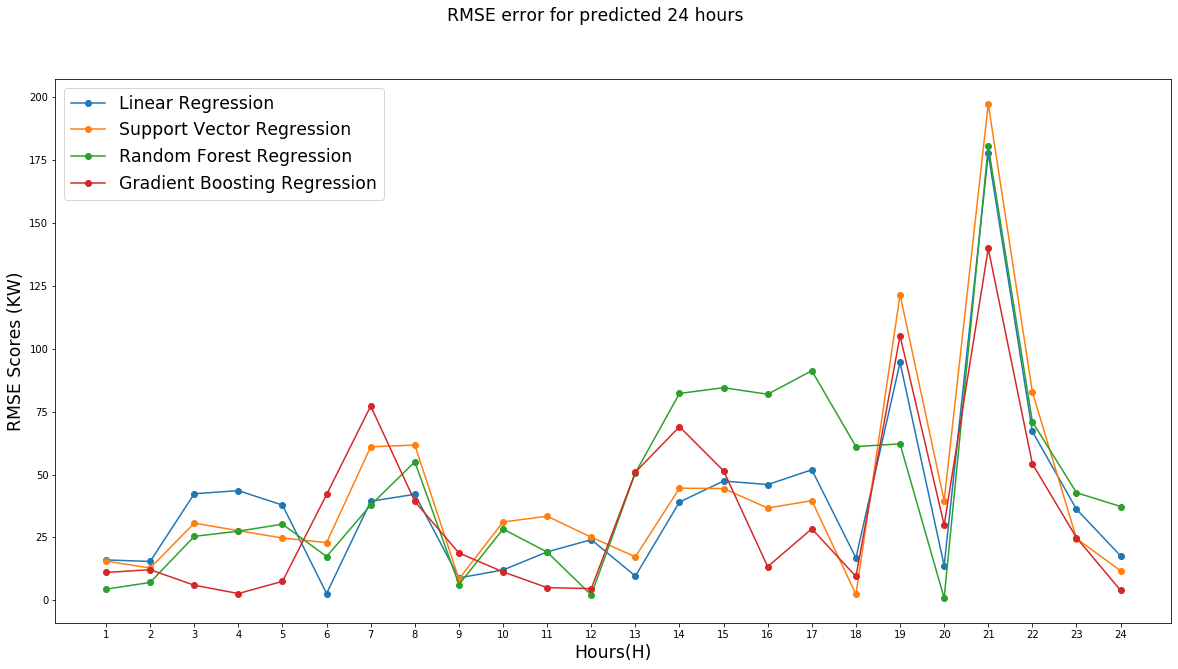

In [45]:
draw_graphs_rmse_scores(final_df_24_hours,hours,'scores')

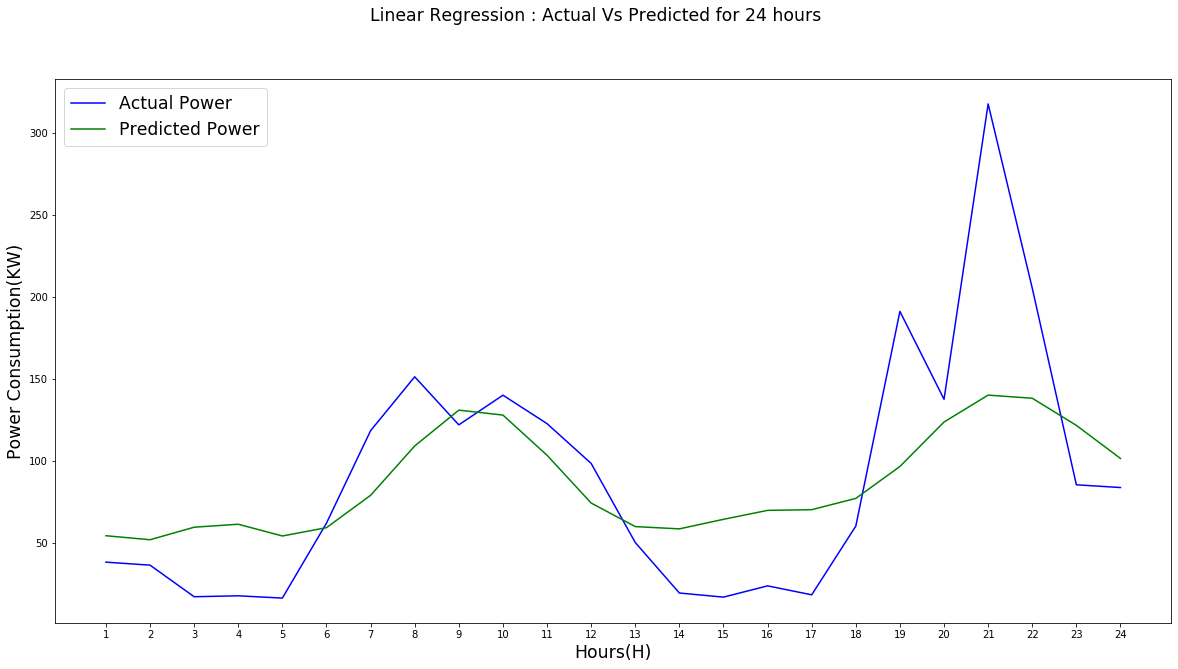

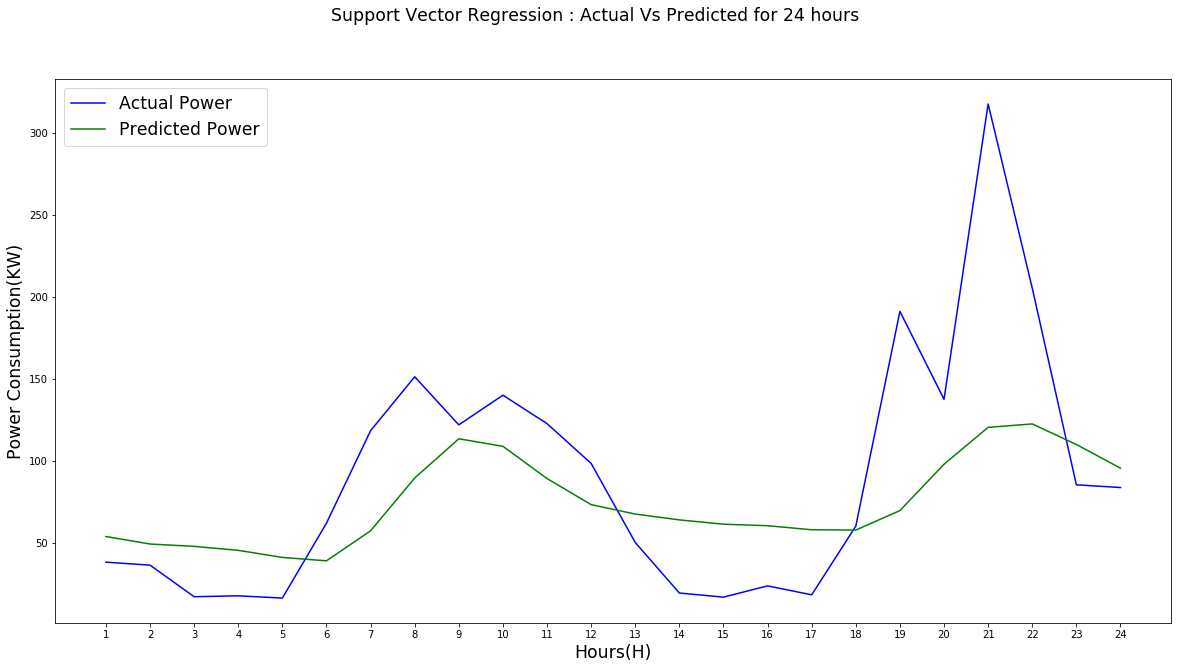

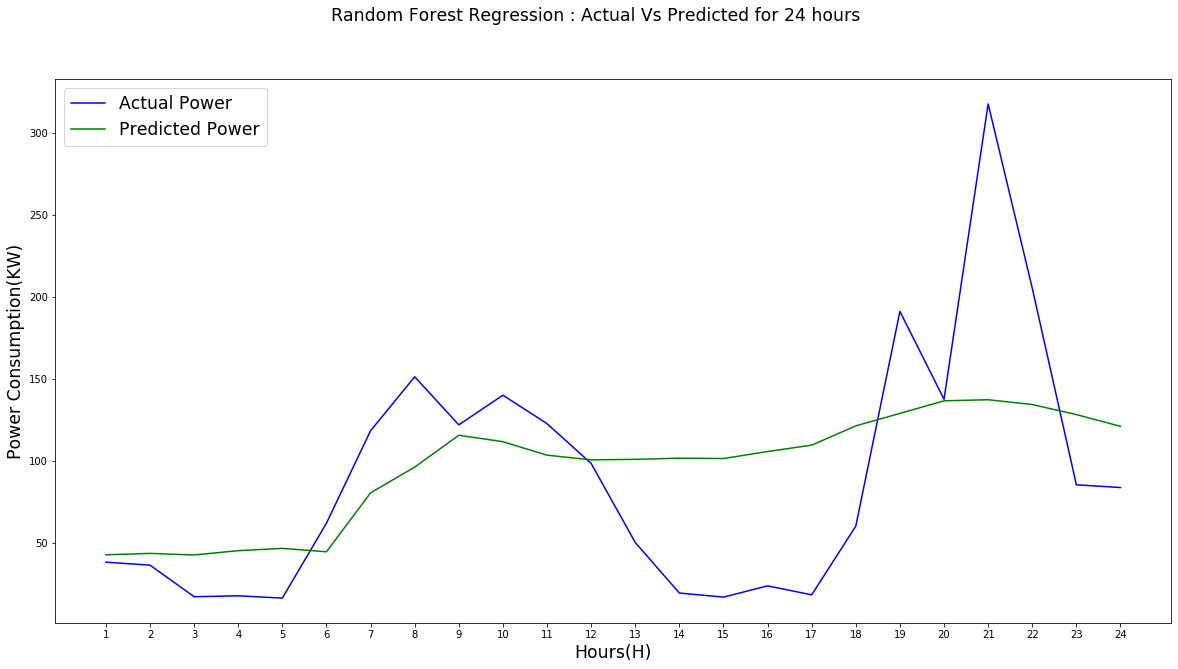

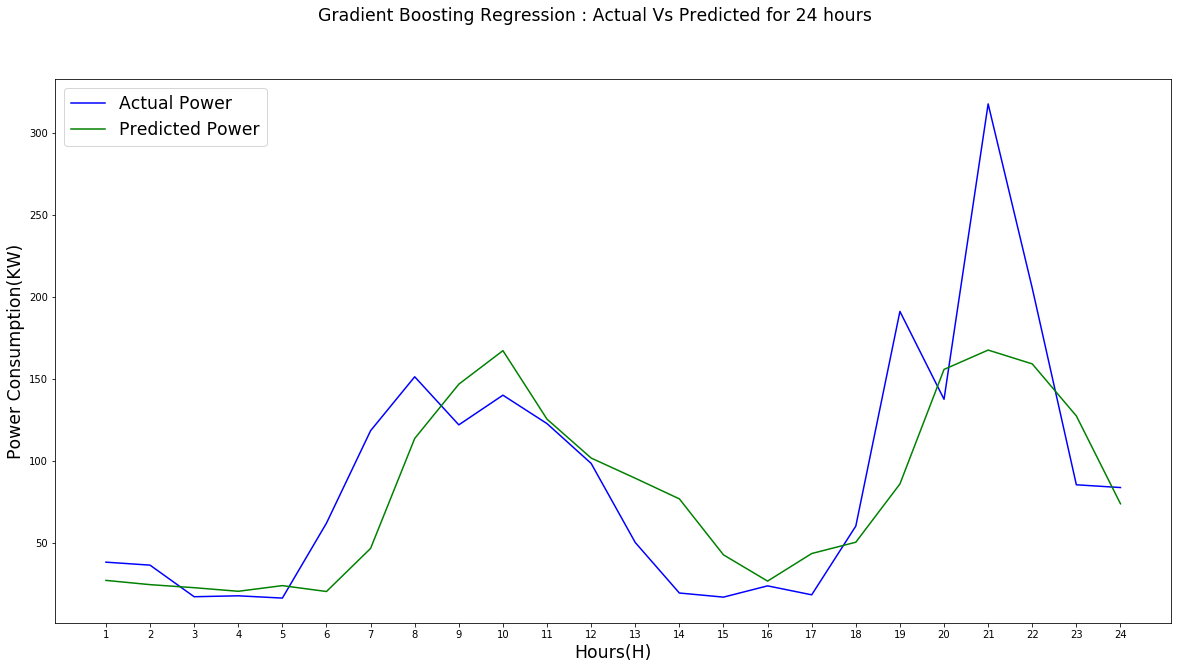

In [44]:
#draw_graphs_predicted_vs_actual(final_df_24_hours,hours)
draw_graphs_predicted_vs_actual_alone(final_df_24_hours,hours)

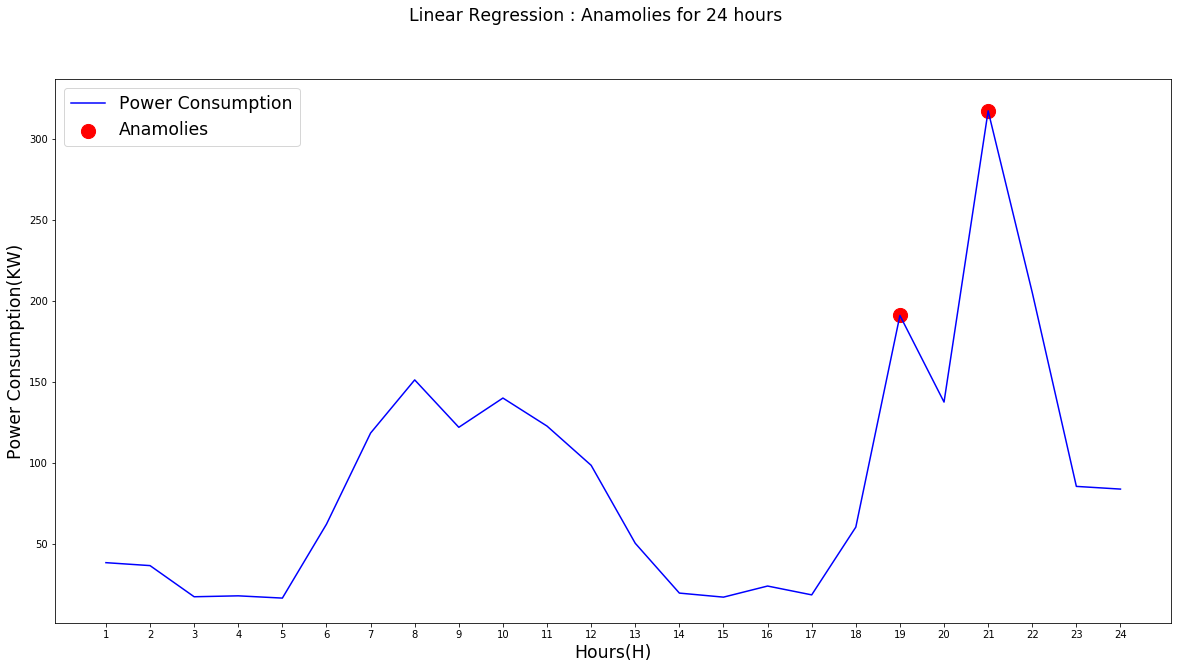

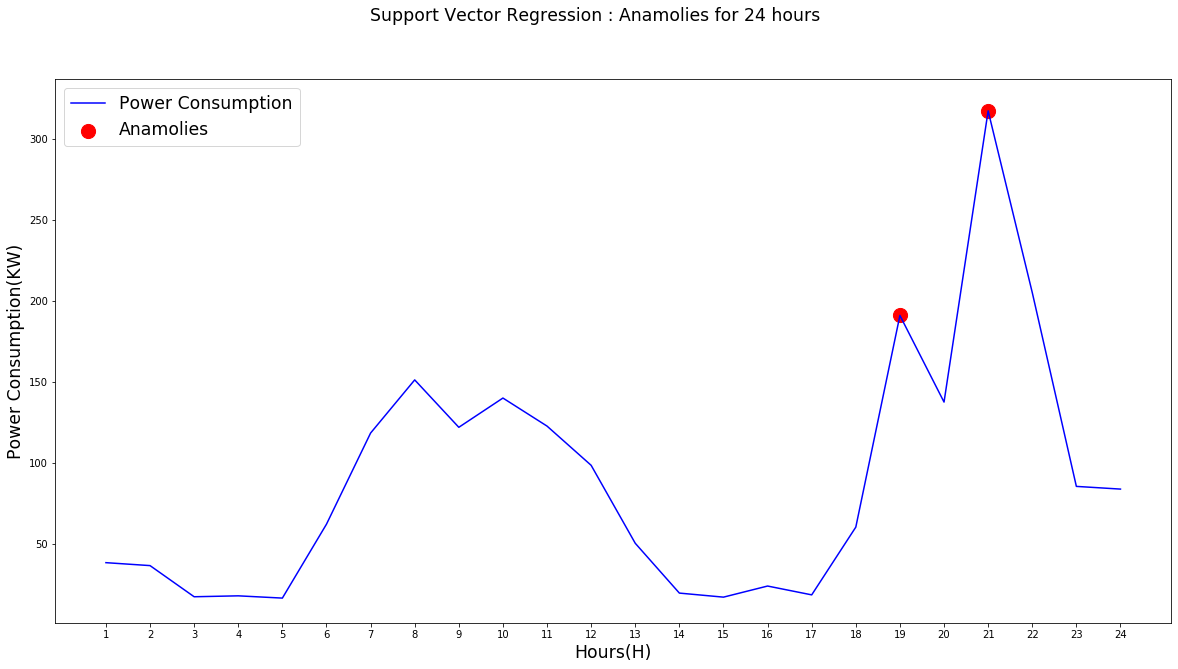

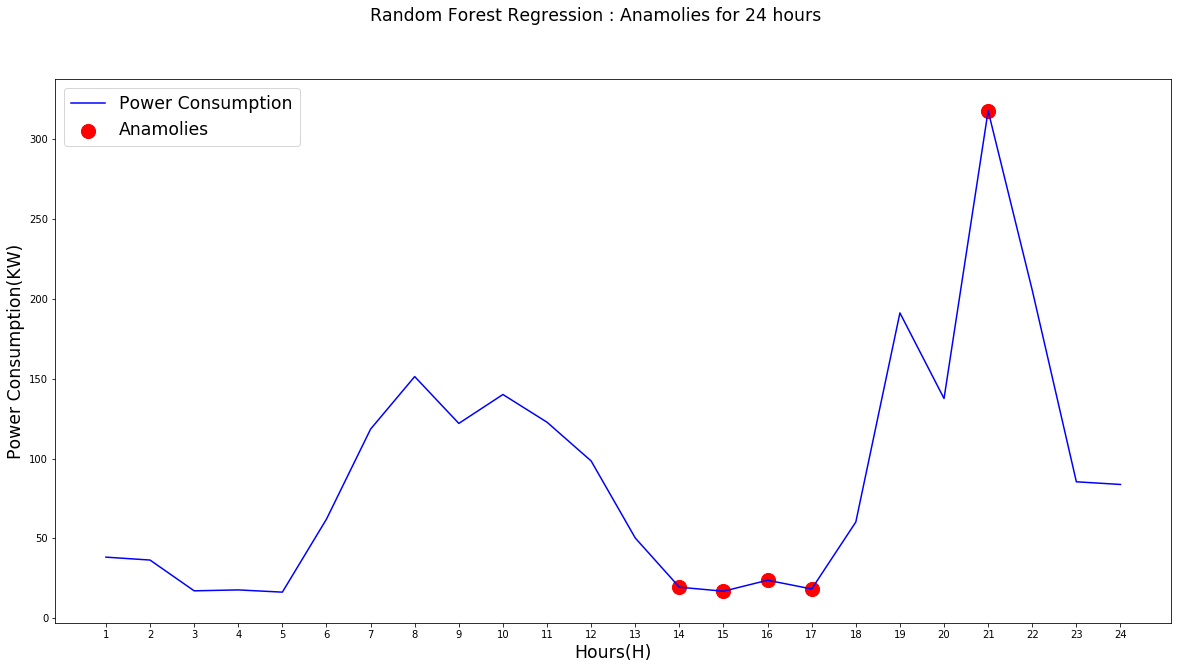

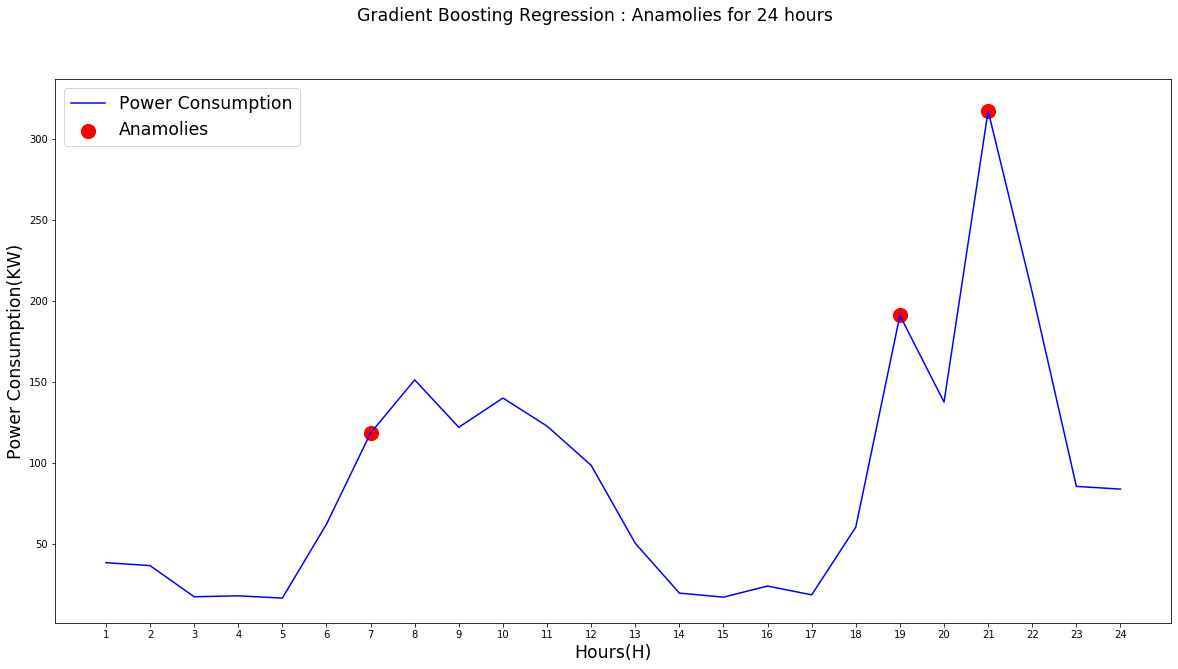

In [45]:
draw_graphs_anamolies_seperately(final_df_24_hours,hours)

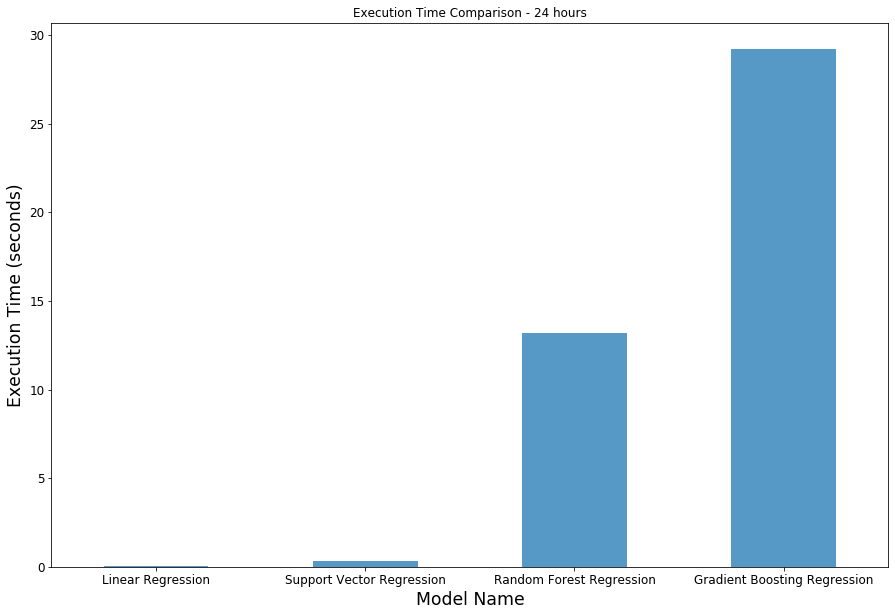

In [46]:
draw_bar_execution_time(final_df_24_hours,str(n_input)+" hours")

In [47]:
#draw_validation_scores_graph(final_df_24_hours,range(1,number_of_folds+1),'validation_scores',n_input)

In [49]:
final_df_24_hours

,anamoly_indices,anamoly_list,anamoly_threshold_std_of_scores,error,execution_time,mape,model_name,predict_flatten,score,scores,test_flatten
0,"[18, 20]","[None, None, None, None, None, None, None, Non...",109.120972,"[16.10358098620172, 15.484850410927884, 42.371...",0.018655,147.560048,Linear Regression,"[54.40558098620171, 51.96885041092786, 59.6016...",52.381728,"[16.10358098620172, 15.484850410927884, 42.371...","[38.30199999999999, 36.48399999999997, 17.2300..."
1,"[18, 20]","[None, None, None, None, None, None, None, Non...",125.649822,"[15.633857287802627, 12.867539688144113, 30.69...",0.278126,126.225899,Support Vector Regression,"[53.93585728780262, 49.351539688144086, 47.923...",58.990588,"[15.633857287802627, 12.867539688144113, 30.69...","[38.30199999999999, 36.48399999999997, 17.2300..."
2,"[13, 14, 15, 16, 20]","[None, None, None, None, None, None, None, Non...",120.532831,"[4.482034811048699, 7.1582163100982825, 25.455...",14.666157,164.934669,Random Forest Regression,"[42.78403481104869, 43.642216310098256, 42.685...",60.625880,"[4.482034811048699, 7.1582163100982825, 25.455...","[38.30199999999999, 36.48399999999997, 17.2300..."
3,"[6, 18, 20]","[None, None, None, None, None, None, 77.178378...",105.332900,"[11.111490099006044, 12.224299063102748, 6.048...",42.995523,149.486666,Gradient Boosting Regression,"[27.19050990099395, 24.259700936897225, 23.278...",48.435439,"[11.111490099006044, 12.224299063102748, 6.048...","[38.30199999999999, 36.48399999999997, 17.2300..."


In [46]:
all_anamoly_indices_24 = final_df_24_hours['anamoly_indices'].values.tolist()
all_anamoly_indices_24

[[18, 20], [18, 20], [13, 14, 15, 16, 20], [6, 18, 20]]

In [47]:
common_anamolies_24 = list(set(all_anamoly_indices_24[0]).intersection(*all_anamoly_indices_24[1:]))
common_anamolies_24

[20]

TEST [38.30199999999999, 36.48399999999997, 17.230000000000004, 17.797999999999995, 16.404, 62.088, 118.418, 151.274, 121.97400000000003, 140.054, 122.71799999999996, 98.476, 50.28200000000002, 19.494, 16.992, 23.852000000000004, 18.396, 60.27600000000002, 191.108, 137.566, 317.56200000000007, 205.29199999999992, 85.44600000000004, 83.77799999999999]


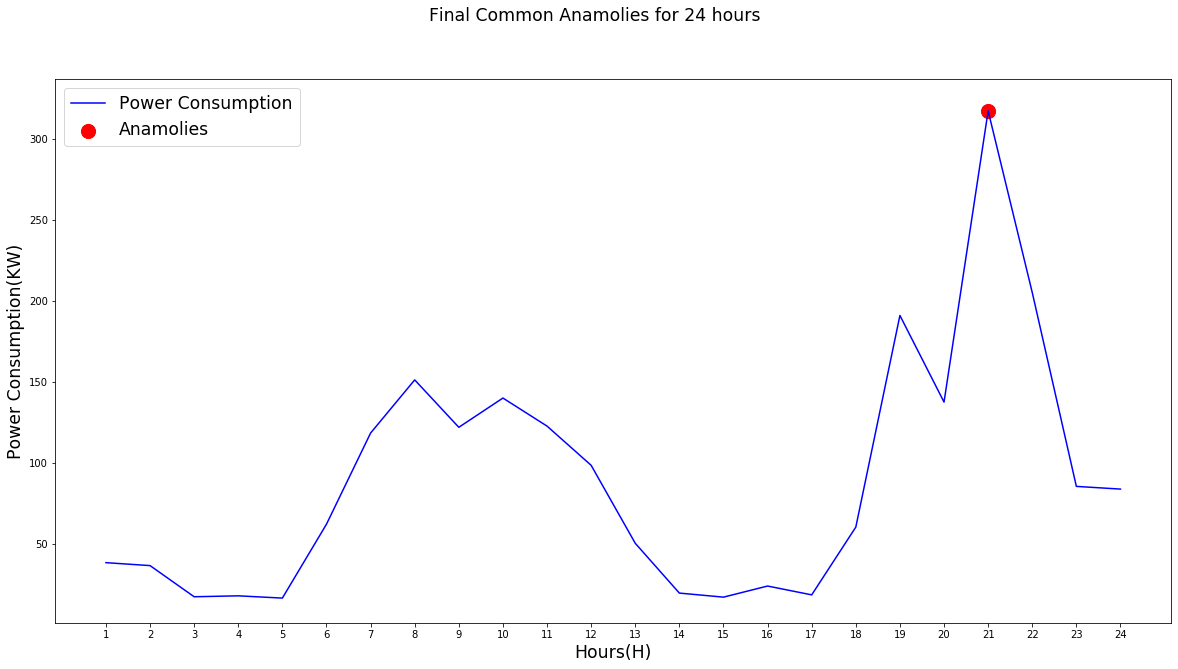

In [48]:
draw_graphs_common_anamolies(final_df_24_hours,hours)

#  Calling for 48 hours

In [51]:
n_input = 48
number_of_folds = 10
hours = list(range(1,n_input+1))
hours = list(map(str, hours))
anamoly_threshold = 90

In [52]:
 models = get_models()

Defined 4 models


In [53]:
models

{'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'Support Vector Regression': SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
     kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
 'Random Forest Regression': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=False,
                       verbose=False, warm_start=False),
 'Gradient Boosting Regression': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='ls', max_depth=3,
                           max_features

In [54]:
#final_output_48_hours = new_evaluation(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_output_48_hours = new_evaluation_without_cross_fold(dataset, n_input,hours,anamoly_threshold,number_of_folds)
final_output_48_hours_df = pd.DataFrame(final_output_48_hours)

Defined 4 models
Linear Regression: [40.598] 5.8, 0.3, 21.6, 22.8, 15.4, 13.0, 24.2, 11.8, 37.4, 12.0, 6.8, 2.9, 35.1, 56.1, 59.5, 53.0, 54.4, 23.2, 78.8, 16.1, 144.5, 42.2, 49.6, 11.9, 17.8, 27.1, 36.5, 36.3, 26.1, 11.9, 1.3, 16.4, 55.0, 44.6, 6.7, 65.3, 38.3, 19.3, 3.9, 18.2, 43.0, 16.2, 81.1, 20.9, 34.3, 30.6, 30.3, 30.7 [130.369]
Support Vector Regression: [43.159] 10.6, 6.0, 31.2, 35.6, 31.9, 19.6, 43.1, 22.2, 33.2, 4.4, 16.5, 13.7, 24.5, 47.8, 50.7, 47.5, 49.0, 11.1, 93.4, 8.1, 144.4, 45.2, 40.2, 8.7, 13.6, 24.9, 26.6, 23.2, 15.0, 8.2, 29.9, 5.4, 42.8, 31.0, 23.2, 75.3, 42.2, 28.3, 21.2, 0.9, 62.7, 10.7, 113.1, 42.6, 23.9, 37.6, 35.4, 30.0 [117.402]
Random Forest Regression: [54.693] 1.2, 2.9, 22.4, 25.6, 29.2, 14.1, 20.3, 14.2, 15.0, 15.5, 10.5, 8.2, 54.4, 85.5, 89.0, 84.9, 96.8, 67.9, 37.2, 30.1, 164.3, 69.6, 37.7, 16.1, 10.9, 68.2, 90.1, 101.7, 99.4, 77.8, 37.9, 20.3, 32.4, 24.0, 4.1, 36.8, 5.1, 26.0, 39.1, 60.7, 0.2, 51.7, 69.2, 33.9, 0.3, 63.4, 44.7, 19.0 [147.681]
Gradient 

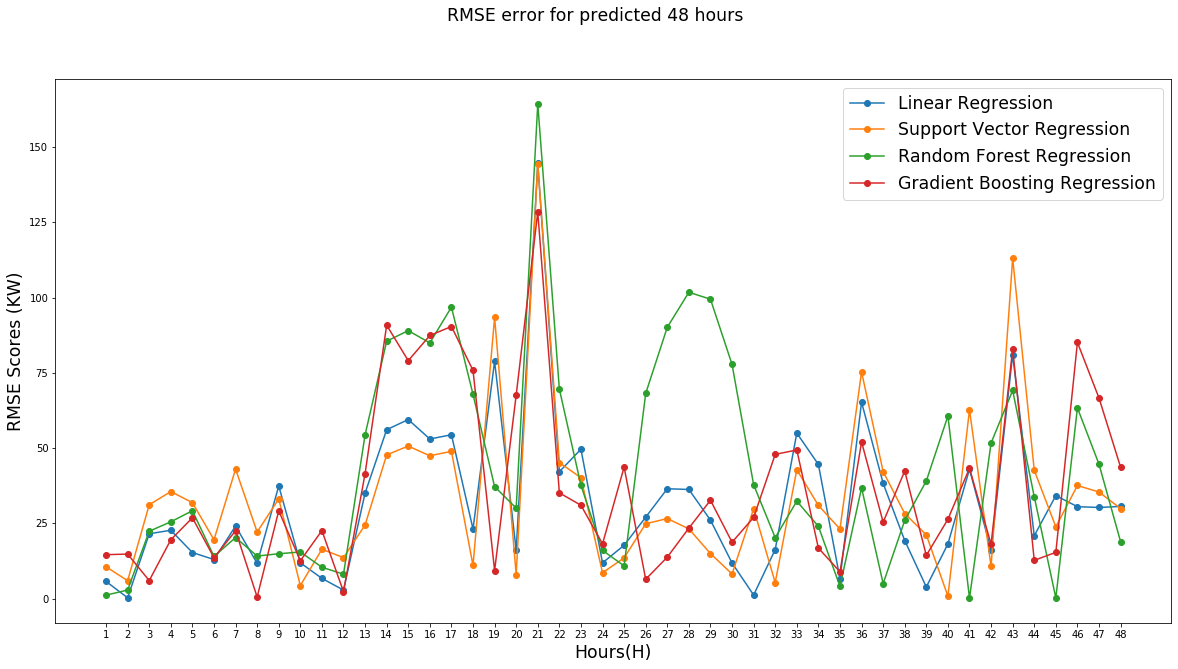

In [55]:
draw_graphs_rmse_scores(final_output_48_hours_df,hours,'scores')

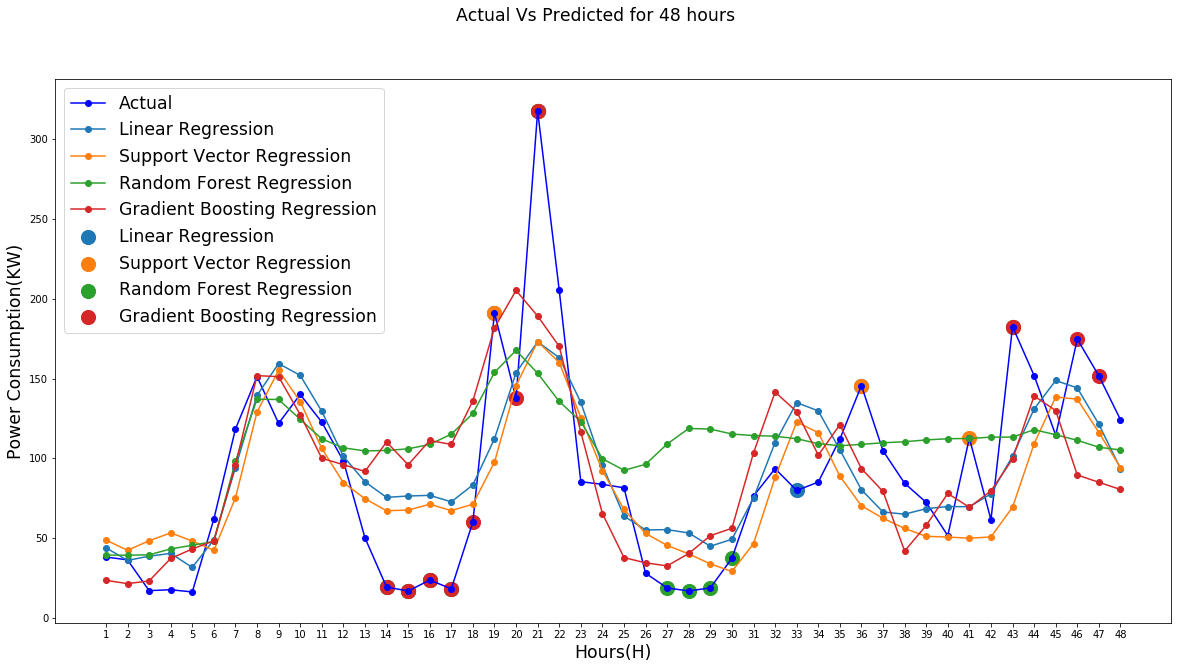

In [56]:
#draw_graphs_predicted_vs_actual(final_output_48_hours_df,hours)
#draw_graphs_predicted_vs_actual_alone(final_output_48_hours_df,hours)
draw_graphs_predicted_vs_actual_combined(final_output_48_hours_df,hours)

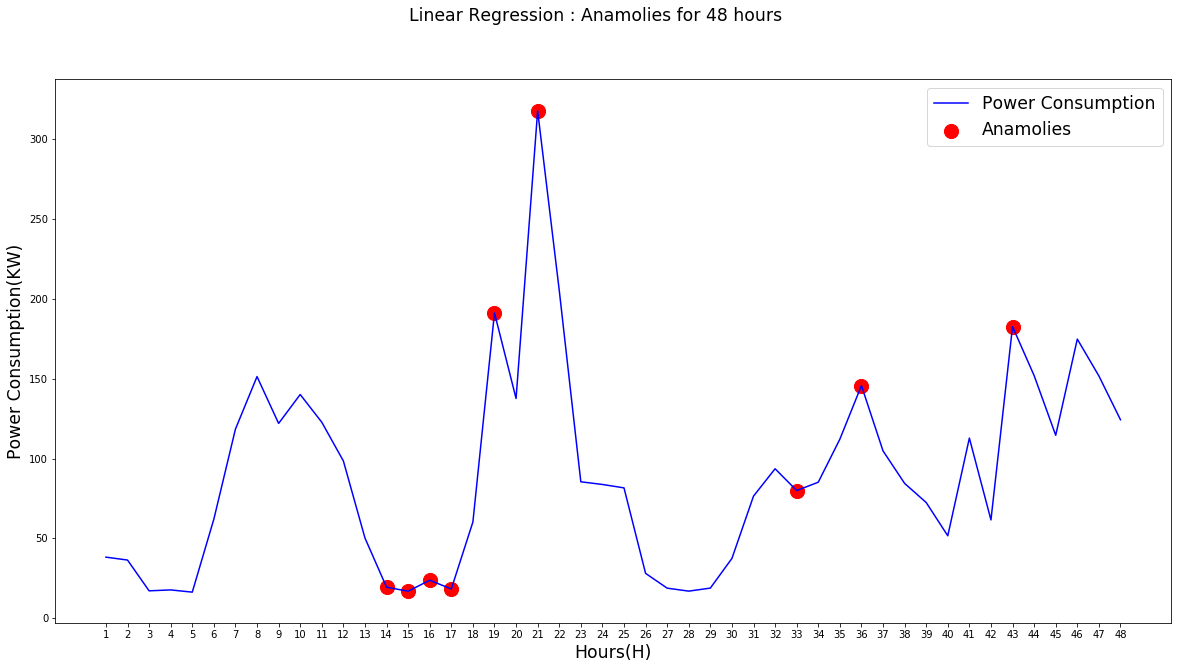

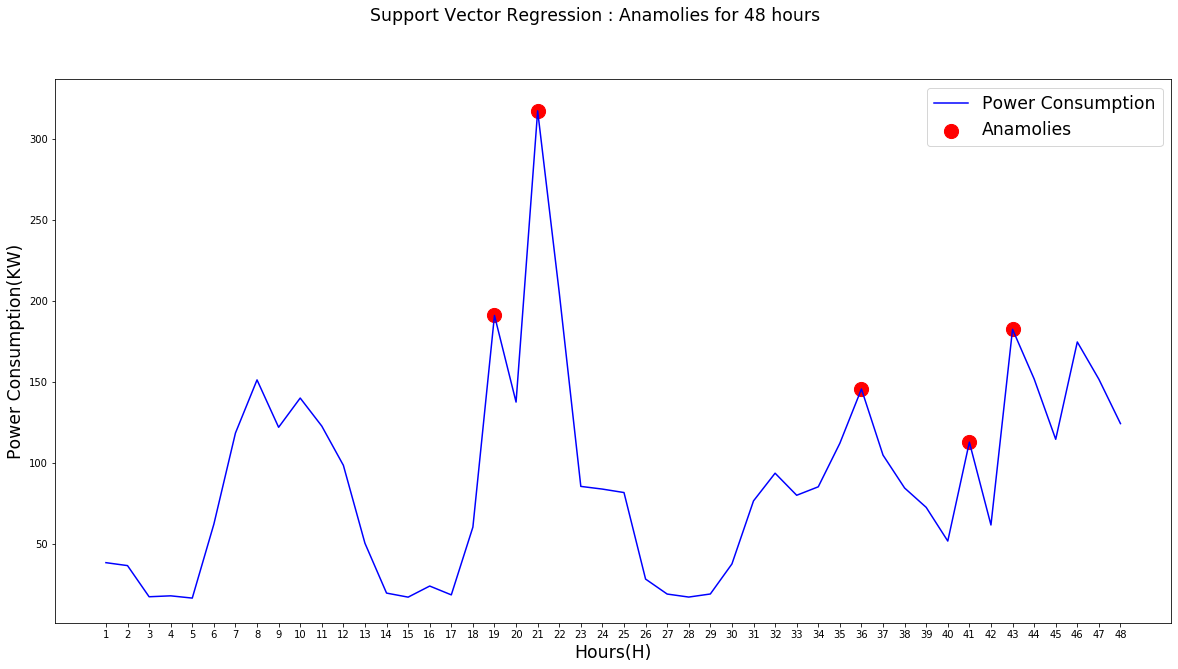

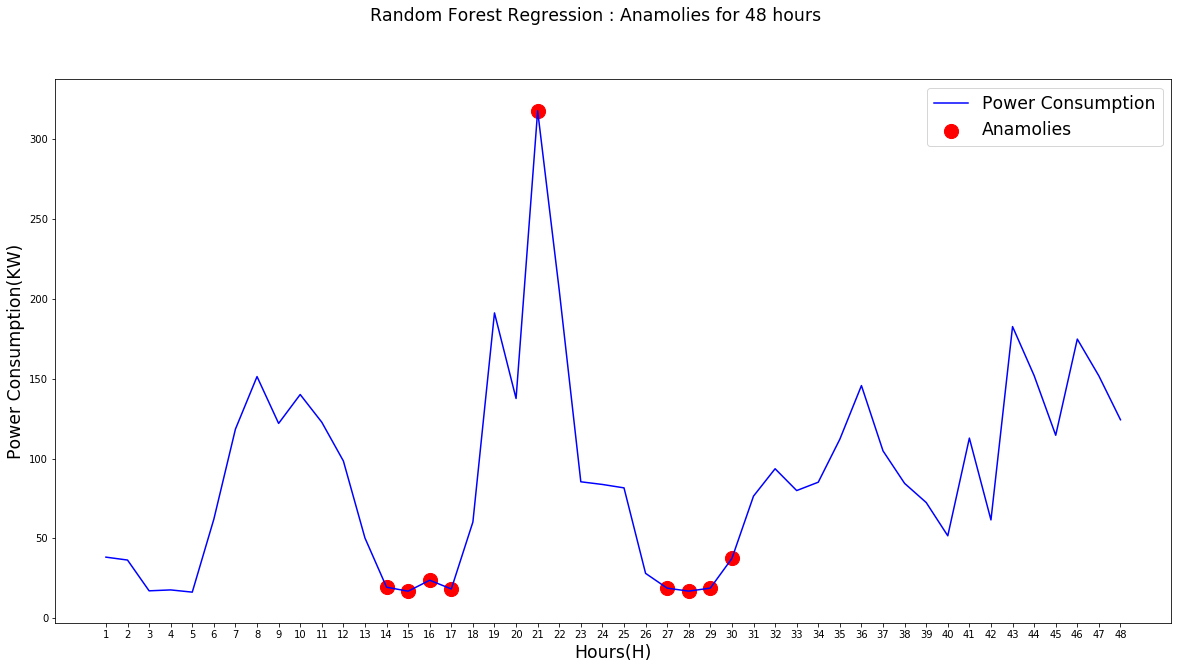

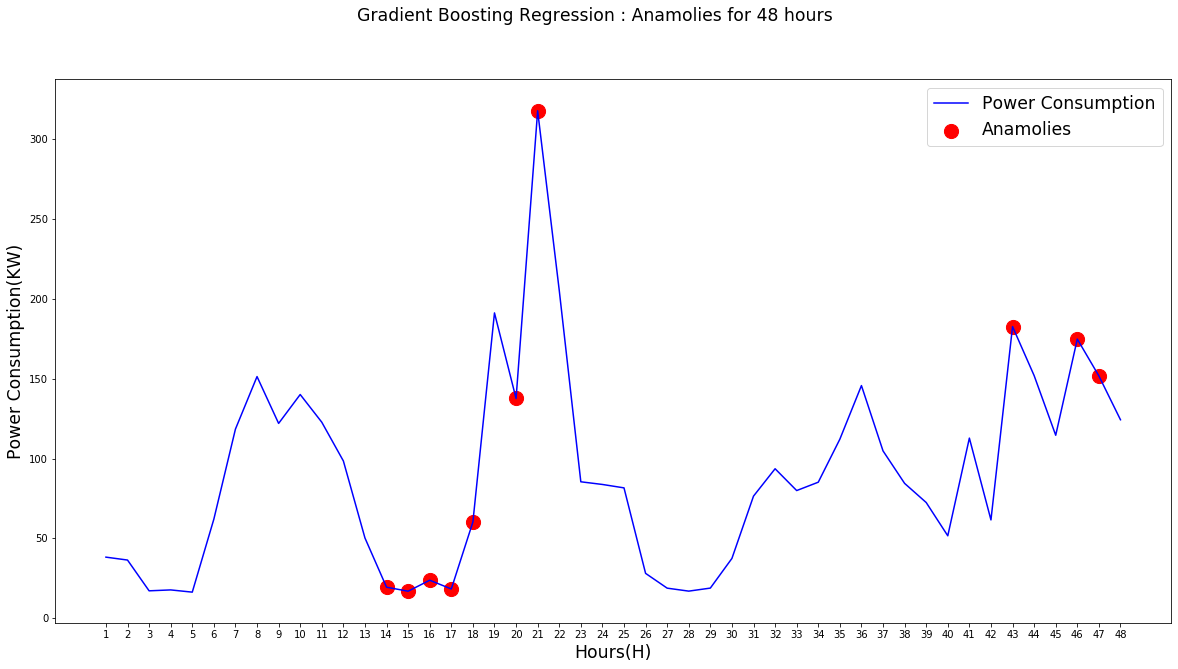

In [57]:
draw_graphs_anamolies_seperately(final_output_48_hours_df,hours)

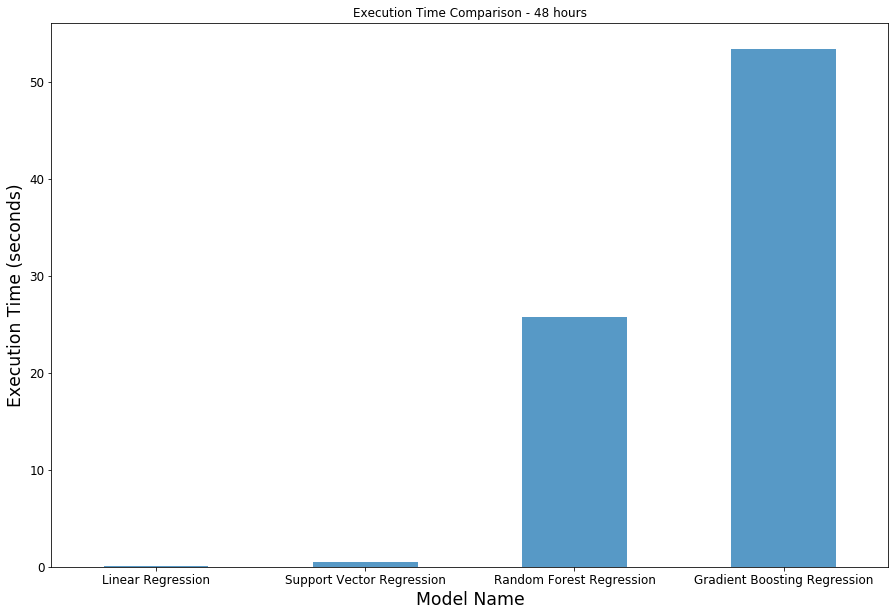

In [58]:
draw_bar_execution_time(final_output_48_hours_df,str(n_input)+" hours")

In [59]:
#draw_validation_scores_graph(final_output_48_hours_df,range(1,number_of_folds+1),'validation_scores',n_input)

In [64]:
#final_graphs_anamolies_seperately(final_output_48_hours_df,hours)

In [61]:
all_anamoly_indices_48 = final_output_48_hours_df['anamoly_indices'].values.tolist()
all_anamoly_indices_48

[[13, 14, 15, 16, 18, 20, 32, 35, 42],
 [18, 20, 35, 40, 42],
 [13, 14, 15, 16, 20, 26, 27, 28, 29],
 [13, 14, 15, 16, 17, 19, 20, 42, 45, 46]]

In [62]:
common_anamolies_48 = list(set(all_anamoly_indices_48[0]).intersection(*all_anamoly_indices_48[1:]))
common_anamolies_48

[20]

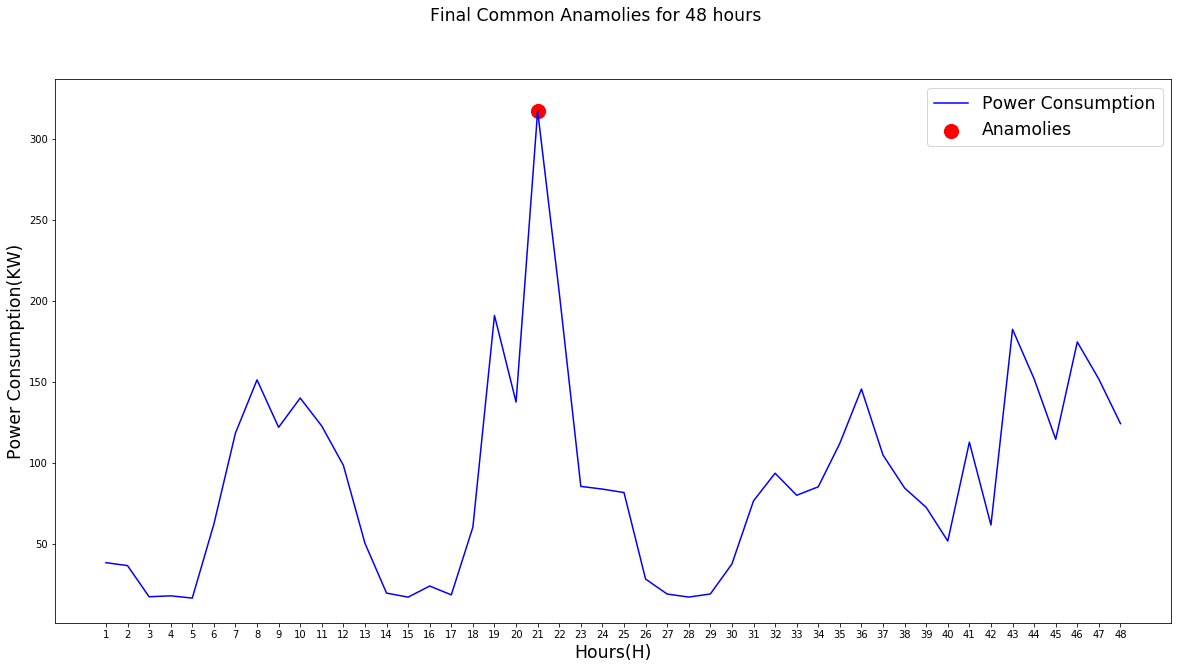

In [63]:
draw_graphs_common_anamolies(final_output_48_hours_df,hours)